In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Read training data
df_train = pd.read_csv('../input/taxihotspotspredict/taxi_data/train_hire_stats.csv')
# df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train.shape

(219599, 4)

In [3]:
#Check weekday & workday
#holidays連假的平常日
#workdays連假的補班日

holidays= {'2016-02-08', '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12','2016-02-29', '2016-04-04', '2016-04-05', '2016-6-9', '2016-6-10', 
'2016-09-15', '2016-09-16', '2016-10-10', '2017-01-02', '2017-01-27', '2017-01-30', '2017-02-01','2017-02-27', '2017-02-28'}
makeupworkdays = {'2016-06-04', '2016-09-10', '2017-02-18'}

In [4]:
df_train.head()

,Zone_ID,Date,Hour_slot,Hire_count
0,1,2016/2/1,0,0
1,1,2016/2/1,1,0
2,1,2016/2/1,2,0
3,1,2016/2/1,3,0
4,1,2016/2/1,4,0


In [5]:
#Declare weekday & workday

isworkday = np.ones((len(df_train),), dtype=int)
weekday = np.ones((len(df_train),), dtype=int)
Yisworkday = np.ones((len(df_train),), dtype=int)
Tisworkday = np.ones((len(df_train),), dtype=int)

In [6]:
#Compute weekday & workday
#weekday()
#0 == Monday, #1 == Tuesday, #2 == Wednesday,  #3 == Thursday,  #4 == Friday,  #5 == Saturday, #6 == Sunday

from datetime import datetime

for index, row in df_train.iterrows():
    row['Date'] = row['Date'].replace('/', '-')
    if row['Date'] in holidays:
        isworkday[index] = 0
    else:
        dd=datetime.strptime(row['Date'], "%Y-%m-%d")
        weekday[index]= dd.weekday() 
        if weekday[index] >=5 and row['Date'] not in makeupworkdays:
            isworkday[index] = 0
    if index > 23:
        Yisworkday[index] = isworkday[index-24]
    if index < len(df_train)-25:
        Tisworkday[index+24] = isworkday[index]

In [7]:
#Build a new dataframe from the training data

RawX = pd.DataFrame(df_train[["Zone_ID", "Hour_slot","Hire_count"]])
RawX['isworkday'] = isworkday
RawX['weekday'] = weekday
RawX['Yisworkday'] = Yisworkday
RawX['Tisworkday'] = Tisworkday

In [8]:
print(RawX.shape)

(219599, 7)


In [9]:
y = RawX["Hire_count"].values
y.shape
RawX=RawX.drop(columns=['Hire_count'])

In [10]:
#See the raw input data

RawX.head()

,Zone_ID,Hour_slot,isworkday,weekday,Yisworkday,Tisworkday
0,1,0,1,0,1,1
1,1,1,1,0,1,1
2,1,2,1,0,1,1
3,1,3,1,0,1,1
4,1,4,1,0,1,1


In [11]:
#Use OneHotEncoder

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')

In [12]:
#Build encoder

enc.fit_transform(RawX)
enc.categories_

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([0, 1]),
 array([0, 1, 2, 3, 4, 5, 6]),
 array([0, 1]),
 array([0, 1])]

In [13]:
#Transform data into one hot vector

X = enc.transform(RawX).toarray()
X.shape

(219599, 62)

In [14]:
#See the cooked input data
X[0:3, :]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.]])

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# create and fit a Baseline Neural Network Model

model = Sequential()
model.add(Dense(128, activation='relu', input_dim=58))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

In [16]:
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X.shape[1]))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))

In [17]:
from tensorflow.keras.optimizers import Adam

model.compile(loss='mse', optimizer=Adam(lr=1e-2,decay=1e-5))
model.fit(X, y, epochs=50, batch_size=5000, verbose=1)

Epoch 1/50
44/44 [==============================] - 2s 3ms/step - loss: 838.3949
Epoch 2/50
44/44 [==============================] - 0s 3ms/step - loss: 118.4965
Epoch 3/50
44/44 [==============================] - 0s 3ms/step - loss: 91.4878
Epoch 4/50
44/44 [==============================] - 0s 3ms/step - loss: 79.8150
Epoch 5/50
44/44 [==============================] - 0s 3ms/step - loss: 78.9374
Epoch 6/50
44/44 [==============================] - 0s 3ms/step - loss: 78.3279
Epoch 7/50
44/44 [==============================] - 0s 3ms/step - loss: 77.8542
Epoch 8/50
44/44 [==============================] - 0s 3ms/step - loss: 78.3317
Epoch 9/50
44/44 [==============================] - 0s 3ms/step - loss: 76.3886
Epoch 10/50
44/44 [==============================] - 0s 3ms/step - loss: 76.8561
Epoch 11/50
44/44 [==============================] - 0s 3ms/step - loss: 76.4706
Epoch 12/50
44/44 [==============================] - 0s 3ms/step - loss: 76.2793
Epoch 13/50
44/44 [================

In [18]:
df_test = pd.read_csv('../input/taxihotspotspredict/taxi_data/test_hire_stats.csv')
df_test.shape

(6048, 5)

In [19]:
#Declare weekday & workday

isworkday2 = np.ones((len(df_test),), dtype=int)
weekday2 = np.ones((len(df_test),), dtype=int)
Yisworkday2 = np.ones((len(df_test),), dtype=int)
Tisworkday2 = np.ones((len(df_test),), dtype=int)

In [20]:
for index, row in df_test.iterrows():
    if row['Date'] in holidays:
        isworkday2[index] = 0
    else:
        dd=datetime.strptime(row['Date'], "%Y-%m-%d")
        weekday2[index]= dd.weekday() 
        if weekday2[index] >=5 and row['Date'] not in makeupworkdays:
            isworkday2[index] = 0
    if index > 23:
        Yisworkday2[index] = Yisworkday2[index-24]
    if index < len(df_test)-25:
        Tisworkday2[index+24] = isworkday2[index]

In [21]:
Test = pd.DataFrame(df_test[["Zone_ID", "Hour_slot"]])
Test['isworkday'] = isworkday2
Test['weekday'] = weekday2
Test['Yisworkday'] = isworkday2
Test['Tisworkday'] = Tisworkday2

In [22]:
Xtest = enc.transform(Test).toarray()
Xtest.shape

(6048, 62)

In [23]:
yt = model.predict(Xtest)

In [24]:
yt = yt.astype(int)

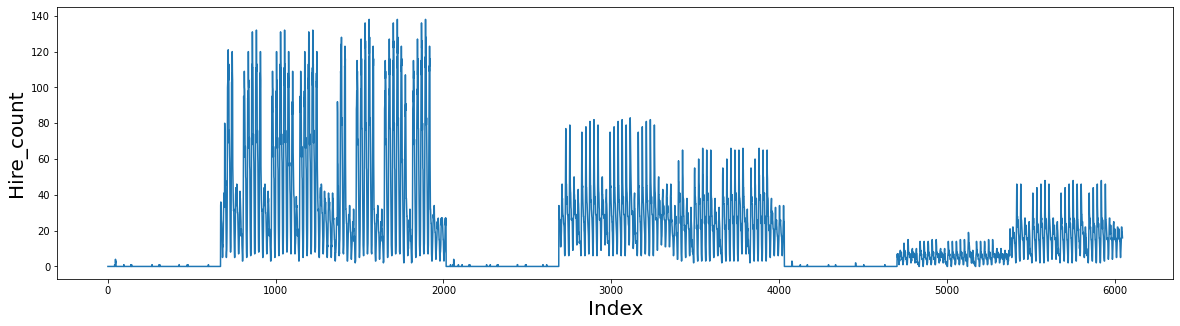

In [25]:
plt.figure(figsize=(20,5))
plt.xlabel('Index',fontsize=20)
plt.ylabel('Hire_count',fontsize=20)
plt.plot(yt)

In [26]:
test_df=pd.read_csv('../input/taxihotspotspredict/taxi_data/test_hire_stats.csv',sep=',')
test_df['Hire_count']=yt
test_df.head()

,Test_ID,Zone_ID,Date,Hour_slot,Hire_count
0,0,7,2017-02-01,0,0
1,1,7,2017-02-01,1,0
2,2,7,2017-02-01,2,0
3,3,7,2017-02-01,3,0
4,4,7,2017-02-01,4,0


In [27]:
test_df['Hire_count']

0        0
1        0
2        0
3        0
4        0
        ..
6043    22
6044    19
6045    19
6046    17
6047    16
Name: Hire_count, Length: 6048, dtype: int64

In [28]:
test_df.to_csv('predict.csv',index=False)